In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

from ggplot import ggplot, aes, geom_boxplot, geom_density, geom_point, geom_histogram, stat_smooth
from ggplot import facet_wrap, facet_grid, ylim, xlim, scale_y_continuous
from scipy.stats.stats import pearsonr
from scipy.stats import mannwhitneyu, linregress
%matplotlib inline

***
**Load Data**

In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
# load in all features except email_address
features_list = data_dict['TOTAL'].keys() # 21 keys: 20 features, 1 label/target
features_list.remove('email_address')
poi_index = features_list.index('poi')
features_list[0], features_list[poi_index] = features_list[poi_index], features_list[0]
all_data = featureFormat(data_dict, features_list, remove_all_zeroes=False, sort_keys = True)
labels, features = targetFeatureSplit(all_data)
index = sorted(data_dict.keys())

In [4]:
email_address = [data_dict[key]['email_address'] for key in index]

**Create DataFrame**

In [5]:
features_data = pd.DataFrame(features, index=index, columns=features_list[1:])
labels_data = pd.Series(labels, index=index)
features_data['email_address'] = email_address

In [6]:
# Recover missing value encoding by replace all 0 with 'NaN'
features_data.replace(0, np.nan, inplace=True) # 146 data points
# In email_address column, missing value is encoded by String type 'NaN'
features_data['email_address'].replace('NaN', np.nan, inplace=True)

**Remove Known Outlier - 'TOTAL'**

In [7]:
features_data.drop('TOTAL', inplace=True)
labels_data.drop('TOTAL', inplace=True) # 145 data points

**Split Train Test Set - only investigate data on training set**

In [8]:
features_train, features_test, labels_train, labels_test = train_test_split(features_data, labels_data,
                                                                            test_size=.3, random_state=852)

**Investigate Missing Value**

In [9]:
features_train.describe() # train: 101 data points; test: 44 data points

,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,salary,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,59.000000,29.000000,8.300000e+01,71.000000,53.000000,74.000000,59.000000,14.000000,87.000000,65.000000,2.00000,59.000000,61.000000,46.000000,62.000000,11.000000,29.000000,42.000000,51.000000
mean,2353.440678,880166.620690,3.226501e+06,3206062.056338,1338181.490566,1359581.418919,1276.593220,916403.357143,3741624.333333,58576.107692,41762500.00000,743.288136,577547.573770,59.608696,292394.161290,87226.909091,-627865.482759,774432.428571,75.862745
std,2873.577809,1414923.171305,1.150331e+07,6328021.679007,1435439.387902,2670741.220860,1226.609542,4188848.353305,7575367.471827,45307.081611,56232666.77386,2172.736222,1671928.021147,120.258699,203931.727353,45791.423097,1070618.751300,966995.700173,75.111389
min,57.000000,-102500.000000,4.750000e+02,3285.000000,100000.000000,-2604490.000000,2.000000,-560222.000000,-44093.000000,475.000000,2000000.00000,12.000000,2.000000,1.000000,477.000000,3285.000000,-3504386.000000,69223.000000,4.000000
25%,693.000000,93585.000000,5.964350e+05,519793.500000,509870.000000,209872.500000,464.000000,-313126.250000,502935.000000,28093.000000,21881250.00000,23.000000,1191.000000,5.000000,210966.000000,67725.000000,-400729.000000,304805.000000,25.000000
50%,1433.000000,214678.000000,1.130461e+06,1324578.000000,750000.000000,452178.500000,856.000000,-110291.500000,1110705.000000,50936.000000,41762500.00000,40.000000,22122.000000,14.500000,259647.500000,102492.000000,-121284.000000,442035.000000,42.000000
75%,2774.500000,875307.000000,2.097314e+06,2250521.500000,1350000.000000,1374893.500000,1972.000000,-51174.500000,2417231.000000,83585.000000,61643750.00000,218.000000,356071.000000,48.000000,314304.250000,114021.000000,-25000.000000,825943.250000,100.000000
max,15149.000000,6426990.000000,1.035598e+08,34348384.000000,7000000.000000,14761694.000000,5521.000000,15456290.000000,49110078.000000,228656.000000,81525000.00000,14368.000000,10359729.000000,609.000000,1111258.000000,137864.000000,-833.000000,5145434.000000,305.000000


In [10]:
df_nan = features_train.isnull()
row_nan = df_nan.sum(axis=1) # count NaNs for each person/index * max value: df_nan.shape[1] = 20
col_nan = df_nan.sum(axis=0) # count NaNs for each column/feature * max value: df_nan.shape[0] = 101

* Investigate missing data distribution on rows/person

In [11]:
row_nan.describe()

count    101.000000
mean       9.772277
std        4.610599
min        2.000000
25%        5.000000
50%       10.000000
75%       13.000000
max       20.000000
dtype: float64

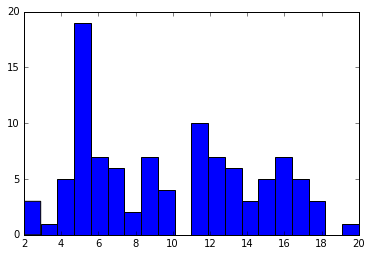

In [12]:
plt.hist(row_nan.values, bins=20) # bins = df_nan.shape[1] -> number of columns/features
plt.show()

In [13]:
# Extract the data points with more than 17 missing attributes/features
ind17 = row_nan.index[row_nan.values>17]
print row_nan.loc[ind17]
ind20 = row_nan.index[row_nan.values==20]

GRAMM WENDY L        18
LOCKHART EUGENE E    20
WHALEY DAVID A       18
WROBEL BRUCE         18
dtype: int64


Almost all samples/data points have certain amount of missing values. Small portion of the sample points have missing values on 18 or larger features. One data point has missing values on all features. It is safe to exclude this data point from dataset (labels_train[ind20] shows that this person is also not a POI).

**Remove Outlier - a data point with no available feature data - 'LOCKHART EUGENE E'**

In [14]:
features_train.drop(ind20[0], inplace=True)
labels_train.drop(ind20[0], inplace=True)

/Users/Zhongyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


* Investigate missing data distributions on columns/features

In [15]:
col_nan.describe()

count    20.000000
mean     49.350000
std      23.976469
min      14.000000
25%      34.500000
50%      42.000000
75%      62.250000
max      99.000000
dtype: float64

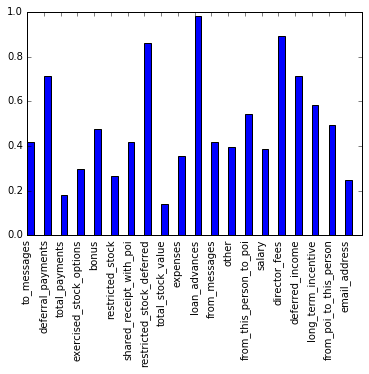

In [16]:
_,ax = plt.subplots()
ind = np.array(range(0,len(col_nan.index)*5,5))
width = 2.
ax.bar(ind, col_nan.values/101., width)
ax.set_xticks(ind)
ax.set_xticklabels(col_nan.index, rotation='vertical')
plt.show()

In [17]:
col_nan_prc = col_nan/float(len(df_nan))
col_nan_prc.order()

total_stock_value            0.138614
total_payments               0.178218
email_address                0.247525
restricted_stock             0.267327
exercised_stock_options      0.297030
expenses                     0.356436
salary                       0.386139
other                        0.396040
shared_receipt_with_poi      0.415842
from_messages                0.415842
to_messages                  0.415842
bonus                        0.475248
from_poi_to_this_person      0.495050
from_this_person_to_poi      0.544554
long_term_incentive          0.584158
deferral_payments            0.712871
deferred_income              0.712871
restricted_stock_deferred    0.861386
director_fees                0.891089
loan_advances                0.980198
dtype: float64

All attributes have missing values. There are 5 attributes having missing values percentages higher than 60%. Discard these 5 attributes as features candidates.
**Remove 5 attributes which have over 60% of missing data**

In [18]:
discard_cols = col_nan_prc.index[col_nan_prc.values>=0.6]
features_train.drop(discard_cols, axis=1, inplace=True) # use axis to inform dropping index or column
features_test.drop(discard_cols, axis=1, inplace=True)

/Users/Zhongyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Zhongyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


**Re-examine the data to do a sanity check**

In [19]:
features_train.describe()

,to_messages,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,salary,long_term_incentive,from_poi_to_this_person
count,59.000000,8.300000e+01,71.000000,53.000000,74.000000,59.000000,87.000000,65.000000,59.000000,61.000000,46.000000,62.000000,42.000000,51.000000
mean,2353.440678,3.226501e+06,3206062.056338,1338181.490566,1359581.418919,1276.593220,3741624.333333,58576.107692,743.288136,577547.573770,59.608696,292394.161290,774432.428571,75.862745
std,2873.577809,1.150331e+07,6328021.679007,1435439.387902,2670741.220860,1226.609542,7575367.471827,45307.081611,2172.736222,1671928.021147,120.258699,203931.727353,966995.700173,75.111389
min,57.000000,4.750000e+02,3285.000000,100000.000000,-2604490.000000,2.000000,-44093.000000,475.000000,12.000000,2.000000,1.000000,477.000000,69223.000000,4.000000
25%,693.000000,5.964350e+05,519793.500000,509870.000000,209872.500000,464.000000,502935.000000,28093.000000,23.000000,1191.000000,5.000000,210966.000000,304805.000000,25.000000
50%,1433.000000,1.130461e+06,1324578.000000,750000.000000,452178.500000,856.000000,1110705.000000,50936.000000,40.000000,22122.000000,14.500000,259647.500000,442035.000000,42.000000
75%,2774.500000,2.097314e+06,2250521.500000,1350000.000000,1374893.500000,1972.000000,2417231.000000,83585.000000,218.000000,356071.000000,48.000000,314304.250000,825943.250000,100.000000
max,15149.000000,1.035598e+08,34348384.000000,7000000.000000,14761694.000000,5521.000000,49110078.000000,228656.000000,14368.000000,10359729.000000,609.000000,1111258.000000,5145434.000000,305.000000


Found that there are two attributes: **restricted_stock** and **total_stock_value** have negative minimum data.

In [20]:
print "count how many data samples have negative restricted_stock: ", (features_train['restricted_stock']<0).sum()
print "count how many data samples have negative total stock value: ", (features_train['total_stock_value']<0).sum()

count how many data samples have negative restricted_stock:  1
count how many data samples have negative total stock value:  1


In [21]:
neg_restricted_stock_index = features_train.index[features_train['restricted_stock']<0]
neg_total_stock_value_index = features_train.index[features_train['total_stock_value']<0]
print neg_restricted_stock_index, neg_total_stock_value_index

Index([u'BHATNAGAR SANJAY'], dtype='object') Index([u'BELFER ROBERT'], dtype='object')


In [22]:
features_train.loc[neg_restricted_stock_index]

,to_messages,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,salary,long_term_incentive,from_poi_to_this_person,email_address
BHATNAGAR SANJAY,523,15456290,2604490,NaN,-2604490,463,NaN,NaN,29,137864,1,NaN,NaN,NaN,sanjay.bhatnagar@enron.com


In [23]:
labels_train.loc[neg_restricted_stock_index]

BHATNAGAR SANJAY    0
dtype: float64

In [24]:
features_train.loc[neg_total_stock_value_index]

,to_messages,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,salary,long_term_incentive,from_poi_to_this_person,email_address
BELFER ROBERT,NaN,102500,3285,NaN,NaN,NaN,-44093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
labels_train.loc[neg_total_stock_value_index]

BELFER ROBERT    0
dtype: float64

After examining the data samples with negative values in **restricted_stock** and **total_stock_value**, there are no abnomalities in other attributes. Since the negative values do not make real sense/do not pass sanity check, discard the two data values and **replace them with NaN**.

In [26]:
features_train['restricted_stock'].loc[neg_restricted_stock_index] = np.nan
features_train['total_stock_value'].loc[neg_total_stock_value_index] = np.nan

/Users/Zhongyu/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/Zhongyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Zhongyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as 

**Bivariant Data Analysis - One Attribute vs. Target/Label Variable**

In [27]:
def normalizer(col):
    avg = col.mean()
    mx  = col.max()
    mn  = col.min()
    std = col.std()
    return (col-mn)/(mx-mn)#(col-avg)/std

In [28]:
# Define two functions for exploring relationship between each attribute and outcome variable
def exp_boxplot_ggplot_series(feature, target):
    df = pd.DataFrame(feature)
    #df = df.apply(normalizer)
    y_label = df.columns[0]
    df['POI'] = target
    df.dropna(inplace=True)
    #rng = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5] -> experiment purpose
    p = ggplot(df, aes(x='POI', y=y_label)) + geom_boxplot() # + scale_y_continuous(limits=(-0.5, 0.5), breaks=rng)
    return p

def exp_boxplot_ggplot_df(features, target, normalizer=None, yrange=None):
    df = features.copy()
    if normalizer:
        df = df.apply(normalizer)
    df['POI'] = target
    df_lng = pd.melt(df, id_vars = 'POI')
    p = ggplot(aes(x='POI', y='value'), data=df_lng) + geom_boxplot()
    p += facet_wrap("variable")
    if yrange:
        ymin = min(yrange)
        ymax = max(yrange)
        p += ylim(ymin, ymax)
    return p

def exp_boxplot_matplt(features, target):
    import pandas as pd
    if isinstance(features, pd.Series):
        boxplot_data = [features[(target==1).values].dropna().values,
                        features[(target==0).values].dropna().values]
        plt.boxplot(boxplot_data, labels= ['POI', 'non-POI'])
        plt.show()
        return
    if isinstance(features, pd.DataFrame):
        cols = features.columns
        n = len(cols)
        i = 1
        for col in cols:
            feature = features[col]
            plt.subplot(1, n, i)
            boxplot_data = [feature[(target==1).values].dropna().values,
                        feature[(target==0).values].dropna().values]
            plt.boxplot(boxplot_data, labels= ['POI', 'non-POI'])
            plt.title(col)
            i += 1
        plt.show()
        return

In [29]:
# Seperate features into two major categories
financial_features = ['salary', 'total_payments', 'bonus', 'total_stock_value', 'expenses',
                      'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock']
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 
                  'from_this_person_to_poi', 'shared_receipt_with_poi']

* Explore financial attributes
    * explore missing value statistics on financial_features
        * make a deep copy of financial_features so that future operation would not impact original data frame
        * attach label column into df_ff to make it easy for furture analysis
        * explore missing value row wise, discard the data points with NaN on all financial features

In [30]:
df_ff = features_train[financial_features].copy()
df_ff['poi'] = labels_train
df_ff_na = df_ff.isnull()
df_ff_na_rows = df_ff_na.sum(axis=1)
na9_ff_index = df_ff.index[df_ff_na_rows==len(financial_features)]
na8_ff_index = df_ff.index[df_ff_na_rows==len(financial_features)-1]
print na9_ff_index

Index([u'POWERS WILLIAM'], dtype='object')


One data point has no available finanical features, therefore discard this row in df_ff to simplify exploring financial features. However, note that this sample can not be dropped in the original data frame since it might have valid email features. The data points with only 1 financial feature available are also printed out for references.

In [31]:
features_train.loc[na9_ff_index]
#print labels_train.loc[na9_ff_index]

,to_messages,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,salary,long_term_incentive,from_poi_to_this_person,email_address
POWERS WILLIAM,653,NaN,NaN,NaN,NaN,12,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN,ken.powers@enron.com


In [32]:
labels_train.loc[na9_ff_index]

POWERS WILLIAM    0
dtype: float64

In [33]:
df_ff = df_ff.drop(na9_ff_index)

In [34]:
df_ff.loc[na8_ff_index]

,salary,total_payments,bonus,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,poi
GRAMM WENDY L,NaN,119292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
SAVAGE FRANK,NaN,3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
CHAN RONNIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32460,0


* Explore financial attributes
    * feature selection based on bivariate analysis on financial attributes w.r.t. target variable

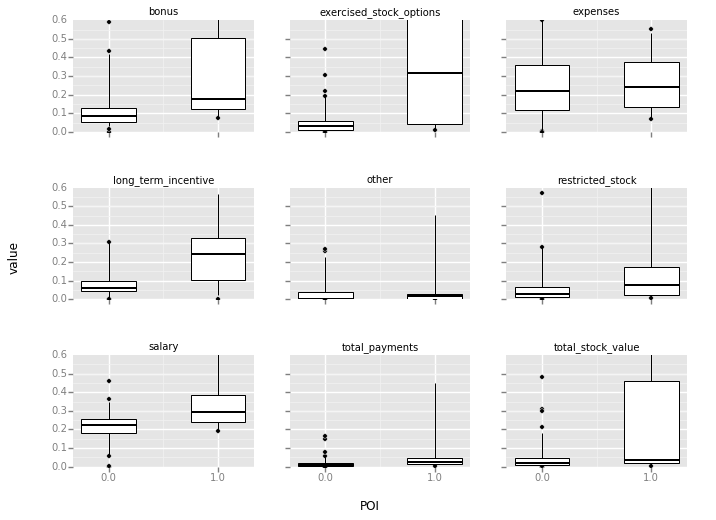

<ggplot: (286743573)>

In [35]:
ff_ps = exp_boxplot_ggplot_df(df_ff.drop(['poi'], axis=1), df_ff['poi'], normalizer=normalizer, yrange=(.0, .6))
ff_ps

The boxplot illustrates that for most of the varibles, the distributions are left skewed: the value ranges of negative samples are narrow but higher density; longer tails on higher value ranges. Compare boxplots by categories, the distributions of **POI** and **non-POI** seperated by features **expenses**, **other**, **total_payments** seem to have little differences. Exclude them as feature candidates.
* Explore financial attributes
    * Explore colinearity within financial features

In [36]:
def calc_pearsonr(df_original):
    df = df_original.copy()
    df = df.apply(normalizer) #optional -> does not change linear statistics
    columns = df.columns
    n = len(columns)
    colinear = {}
    for colx in columns:
        cols = ['_m', '_r', '_r2', '_p']
        cols = [colx+s for s in cols]
        index = []
        vals = []
        for coly in columns:
            index.append(coly)
            x = df[colx].copy()
            y = df[coly].copy()
            # extract the samples with no missing values in x and y
            na_x = x.isnull()
            na_y = y.isnull()
            na_either = na_x | na_y 
            na_index = df.index[na_either]
            x.drop(na_index, inplace=True)
            y.drop(na_index, inplace=True)
            m = len(x)
            r, p = pearsonr(x, y)
            vals.append([m, r, r**2, p])
        df_temp = pd.DataFrame(vals, index=index, columns=cols)
        colinear[colx] = (df_temp)
    return colinear

In [37]:
colinear_stat = calc_pearsonr(df_ff.drop(['poi'], axis=1))

In [38]:
colinear_stat['expenses']

,expenses_m,expenses_r,expenses_r2,expenses_p
salary,56,0.132775,0.017629,0.329306
total_payments,65,0.109747,0.012044,0.384153
bonus,49,-0.017618,0.000310,0.904364
total_stock_value,60,0.046740,0.002185,0.722871
expenses,65,1.000000,1.000000,0.000000
exercised_stock_options,46,0.058066,0.003372,0.701493
other,54,0.069138,0.004780,0.619354
long_term_incentive,36,-0.150290,0.022587,0.381628
restricted_stock,54,0.026078,0.000680,0.851521


   * **expenses** is not statistically correlated with any features (big p-value). It is safely discard it as a feature candidate

In [39]:
colinear_stat['total_payments']

,total_payments_m,total_payments_r,total_payments_r2,total_payments_p
salary,62,0.609404,0.371374,1.468131e-07
total_payments,83,1.000000,1.000000,0.000000e+00
bonus,53,0.634809,0.402982,3.308626e-07
total_stock_value,71,0.687414,0.472538,3.570506e-11
expenses,65,0.109747,0.012044,3.841527e-01
exercised_stock_options,57,0.610894,0.373192,4.498095e-07
other,61,0.838737,0.703479,3.263832e-17
long_term_incentive,42,0.549531,0.301985,1.637328e-04
restricted_stock,61,0.638633,0.407853,3.064089e-08


In [40]:
colinear_stat['other']

,other_m,other_r,other_r2,other_p
salary,58,0.627978,0.394357,1.315817e-07
total_payments,61,0.838737,0.703479,3.263832e-17
bonus,51,0.472754,0.223496,4.599084e-04
total_stock_value,57,0.649027,0.421236,4.746597e-08
expenses,54,0.069138,0.004780,6.193535e-01
exercised_stock_options,44,0.559073,0.312563,7.990502e-05
other,61,1.000000,1.000000,0.000000e+00
long_term_incentive,41,0.611501,0.373933,2.162993e-05
restricted_stock,54,0.662451,0.438841,4.866008e-08


* Explore financial attributes
    * Explore the missing samples in **other** and **total_payments**

In [41]:
na_index_other = df_ff.index[df_ff['other'].isnull()]
na_index_totpy = df_ff.index[df_ff['total_payments'].isnull()]

In [42]:
print set(na_index_other)&set(na_index_totpy) == set(na_index_totpy)

True


* The sample points which do not have valid data in **total_payments** also do not have valid data in **other**. na_index_totpy is a subset of na_index_other
* Decide **strategy for missing value imputation**
    * Fill missing values in **total_payments** using categorical(POI vs non-POI) average/median
    * Fill in missing values in **other** using categorical linear regression (or other regression techniques) from **total_payments**
        * Need to investigate scatter plot first
        * Need to investigate categorized pearson r and coefficient of determination r^2 first
    * Use imputed **other** and **total_payments** and multilinear regression (or other regression technique) to impute the rest financial features
***
* Do a hypothesis test to see if the average of **total_payments** in POI vs non-POI is statistically different
    * If the distribution is semi-normal/bell curve shape, do a t-test
    * If the distribution is very not normal, do a Mann-Whiteney U test

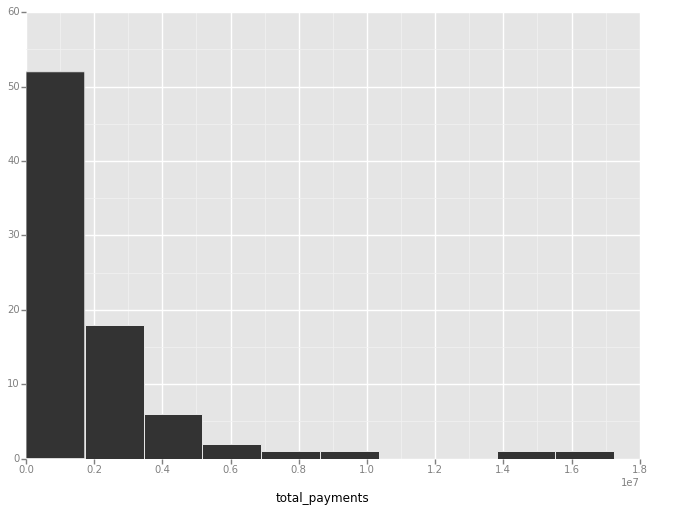

<ggplot: (272656417)>

In [43]:
# Examine distribution characteristics using histogram - overall histgoram vs. categorically seperated histgoram
outlier_index = df_ff.index[df_ff['total_payments']==df_ff['total_payments'].max()]
ggplot(df_ff.drop(outlier_index), aes(x='total_payments')) + geom_histogram()

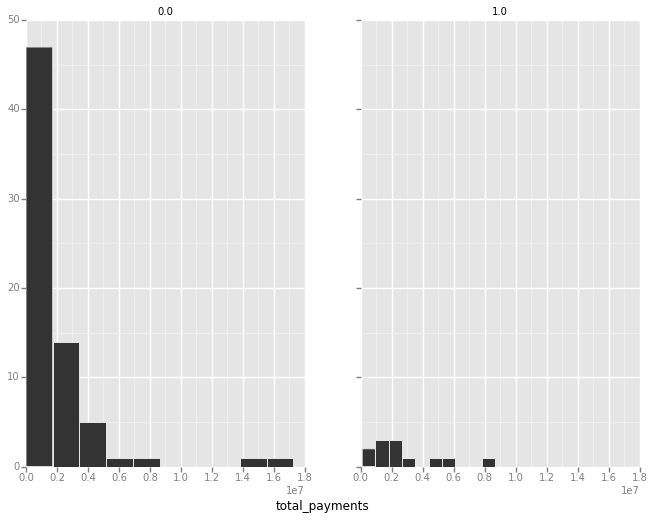

<ggplot: (291904113)>

In [44]:
ggplot(df_ff.drop(outlier_index), aes(x='total_payments')) + geom_histogram() + facet_wrap("poi",ncol=2)

Perform Non-parametric Mann-Whitney U Test to test the null hypothesis that the mean of **total_payments** of **POI** is statistically not different from the **non-POI** group.

In [45]:
def group_seperator(features, target, outlier_ids=None):
    if outlier_ids is not None:
        pos_index = target.index.drop(outlier_ids)[target.drop(outlier_ids)==1]
        neg_index = target.index.drop(outlier_ids)[target.drop(outlier_ids)==0]
    else:
        pos_index = target.index[target==1]
        neg_index = target.index[target==0]
    pos_feats = features.loc[pos_index]
    neg_feats = features.loc[neg_index]
    return pos_feats.dropna(), neg_feats.dropna()

In [46]:
# Include the outlier impact
pos_totpay, neg_totpay = group_seperator(df_ff['total_payments'], df_ff['poi'])
mwu_stat, mwu_p = mannwhitneyu(pos_totpay, neg_totpay)
print mwu_p

0.0194530636418


In [47]:
# Exclude the outlier impact
pos_totpay1, neg_totpay1 = group_seperator(df_ff['total_payments'].drop(outlier_index), 
                                            df_ff['poi'].drop(outlier_index))
mwu_stat1, mwu_p1 = mannwhitneyu(pos_totpay1, neg_totpay1)
print mwu_p1

0.0468581860835


The Mann-Whitney U Test P values with/without the maximum outlier impact are both less than 0.05. Therefore reject the null hypothesis, and the means of **total_payments** of **POI** and **non-POI** groups are statistically different. 
* Therefore, compute the filling value sperately. Given that the histograms are extremely non-bell-curvy, and suffers from outliers, decide to use median to as the filling value for NaN.

In [48]:
median_pos_totpay = pos_totpay.median()
median_neg_totpay = neg_totpay.median()
print median_pos_totpay, median_neg_totpay
print df_ff['total_payments'].median()

2424083.0 1074324.0
1130461.0


* Impute missing values in **total_payments** using median value of the whole samples

Note: df_ff is a deep copy of a slice of the original data frame. Alternation on df_ff will not be reflected in features_train. In order to keep a record of original slice of the data frame for comparison purpose, the imputation is performed on a deep copy slice of the original data frame -> df_ff_copy.

In [175]:
def impute_feat_na(feat, target, method=None, outlier_ids=None):
    # impute missing values in given with categorical statistical parameters
    pos_feat, neg_feat = group_seperator(feat, target, outlier_ids)
    if method==None or method=='mean':
        fill_pos_feat = pos_feat.mean()
        fill_neg_feat = pos_feat.mean()
    elif method=='median': 
        fill_pos_feat = pos_feat.median()
        fill_neg_feat = neg_feat.median()
    elif method=='mode':
        fill_pos_feat = pos_feat.mode()
        fill_neg_feat = neg_feat.mode()
    else:
        fill_pos_feat = pos_feat.map(method)
        fill_neg_feat = pos_feat.map(method)
    na_index_pos = set(feat.index[target==1]) & set(feat.index[feat.isnull()])
    na_index_neg = set(feat.index[target==0]) & set(feat.index[feat.isnull()])
    feat_copy = feat.copy()
    fill = (fill_pos_feat+fill_neg_feat)/2.
    feat_copy.loc[na_index_pos] = fill
    feat_copy.loc[na_index_neg] = fill
    return feat_copy, fill

In [49]:
df_ff_copy = features_train[financial_features].copy()
df_ff_copy['poi'] = labels_train
totpay_impute_param = df_ff_copy['total_payments'].median()
df_ff_copy['total_payments'].fillna(totpay_impute_param, inplace=True)
#totpay_impute_params = impute_feat_na(df_ff_copy['total_payments'], labels_train, method='median')
#df_ff_copy['total_payments'] = totpay_impute_params[0]

***
* Fill in missing values in **other** using categorical linear regression (or other regression techniques) from **total_payments**
    * Do a scatter plot to check if the it violates any simple linear regression assumptions

In [329]:
dft = df_ff_copy.drop(outlier_index)
outlier2 = dft.index[dft['total_payments']==dft['total_payments'].max()]

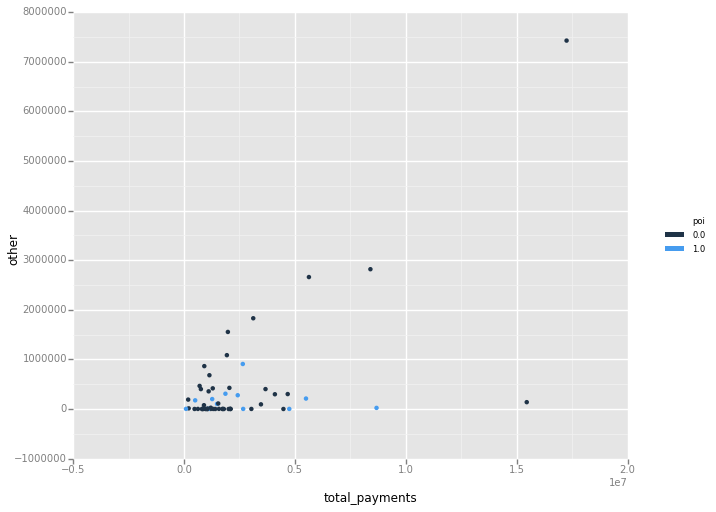

<ggplot: (291620057)>

In [50]:
ggplot(df_ff.drop(outlier_index), aes(x='total_payments', y='other', color='poi'))\
+ geom_point() #+ scale_y_continuous(limits=(-5., 3000000)) # change limits range to adjust visulization of the plot

* The scatter plot indicates that despite **other** and **total_payments** positively correlated with each other, there is no clear linear or polynomial relationship between each other. Therefore discard the plan of using **total_payments** to fill in missing values in **other**, simple discard **other** as a feature.
***
* Investigate stock features: **total_stock_value**, **exercised_stock_options**, **restricted_stock**. Decide feature selection and strategy for filling missing values for stock features.
    * examine correlations among stock features
    * examine missing value distributions among stock features
    * determine strategy for filling in missing values in stock features
        * explore stock features histogram/distribution features
        * plot scatter plots of stock features to explore possibilities of using regression techniques to filling in missing values
    * consider combine stock features into one single stock feature as simplicity
***
* examine correlations among stock features

In [51]:
colinear_stat['total_stock_value']

,total_stock_value_m,total_stock_value_r,total_stock_value_r2,total_stock_value_p
salary,59,0.691062,0.477567,1.376371e-09
total_payments,71,0.687414,0.472538,3.570506e-11
bonus,51,0.584549,0.341698,6.669545e-06
total_stock_value,86,1.000000,1.000000,0.000000e+00
expenses,60,0.046740,0.002185,7.228711e-01
exercised_stock_options,69,0.963200,0.927755,5.932075e-40
other,57,0.649027,0.421236,4.746597e-08
long_term_incentive,40,0.558871,0.312337,1.780911e-04
restricted_stock,71,0.864020,0.746530,3.004789e-22


In [52]:
colinear_stat['restricted_stock']

,restricted_stock_m,restricted_stock_r,restricted_stock_r2,restricted_stock_p
salary,56,0.572283,0.327508,4.064079e-06
total_payments,61,0.638633,0.407853,3.064089e-08
bonus,51,0.433801,0.188183,1.471756e-03
total_stock_value,71,0.864020,0.746530,3.004789e-22
expenses,54,0.026078,0.000680,8.515214e-01
exercised_stock_options,54,0.714450,0.510439,1.304509e-09
other,54,0.662451,0.438841,4.866008e-08
long_term_incentive,37,0.813528,0.661827,9.344145e-10
restricted_stock,73,1.000000,1.000000,0.000000e+00


Three variables descirbing features of stocks: **total_stock_value**, **exercised_stock_options**, **restricted_stock** are strongly correlated. The missing value amount: **total_stock_value** < **restricted_stock** < **exercised_stock_options**.
***
* Examine the missing value samples' distributions among stock features

In [53]:
na_totstock_index = df_ff.index[df_ff["total_stock_value"].isnull()]
na_exestock_index = df_ff.index[df_ff['exercised_stock_options'].isnull()]
na_rststock_index = df_ff.index[df_ff['restricted_stock'].isnull()]
na_stock_index = set(na_totstock_index) & set(na_exestock_index) & set(na_rststock_index)
na_ind1 = set(na_totstock_index) - (set(na_totstock_index)&set(na_exestock_index))
print len(na_totstock_index), len(na_exestock_index), len(na_rststock_index)
print na_stock_index == set(na_exestock_index) & set(na_rststock_index), len(na_stock_index)
print len(na_ind1)
print set(na_totstock_index) & set(na_rststock_index) == na_stock_index

13 28 26
True 9
2
False


1) There are 9 data points/person having no data collection on their stock infomation (missing values in **total_stock_value**, **exercised_stock_options** and **restricted_stock**).

2) There are 11 data points/person with missing values in **total_stock_value** and **exercised_stock_options**. There is 2 data point/person has **exercised_stock_options** but does not have **total_stock_value**.
    * Examine these 2 speical person

In [54]:
features_train.loc[na_ind1]

,to_messages,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,salary,long_term_incentive,from_poi_to_this_person,email_address
BELFER ROBERT,NaN,102500,3285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BHATNAGAR SANJAY,523,15456290,2604490,NaN,NaN,463,NaN,NaN,29,137864,1,NaN,NaN,NaN,sanjay.bhatnagar@enron.com


In [55]:
print neg_total_stock_value_index
print neg_restricted_stock_index

Index([u'BELFER ROBERT'], dtype='object')
Index([u'BHATNAGAR SANJAY'], dtype='object')


The 2 person who have **exercised_stock_options** but do not have **total_stock_value** are the 2 person with negative invalid values in **total_stock_values** / **restricted_stock**.

Note: Restricted stock, also known as letter stock or restricted securities, refers to stock of a company that is not fully transferable (from the stock-issuing company to the person receiving the stock award) until certain conditions (restrictions) have been met.
***
**Missing Value Imputation Strategy for Stock Features**
* Imputate missing values in **total_stock_value** using mean/median/mode -> need to fill in 12 missing values

* (Do hypothesis test to decide if seperate linear models need to be fitted for **POI** and **non-POI**.) Use simple linear regression (remove outliers) to imputate missing values in **exercised_stock_options** from **total_stock_value**
* ( Do hypothesis test to decide if seperate linear models need to be fitted for **POI** and **non-POI** (optional-skip))Use **total_stock_value** (and **exercised_stock_options**) to train linear regression model (remove outliers), use it to imputate missing **restricted_stock** values -> need to fill 25 missing values
***
* step 1: impute missing values in **total_stock_value**

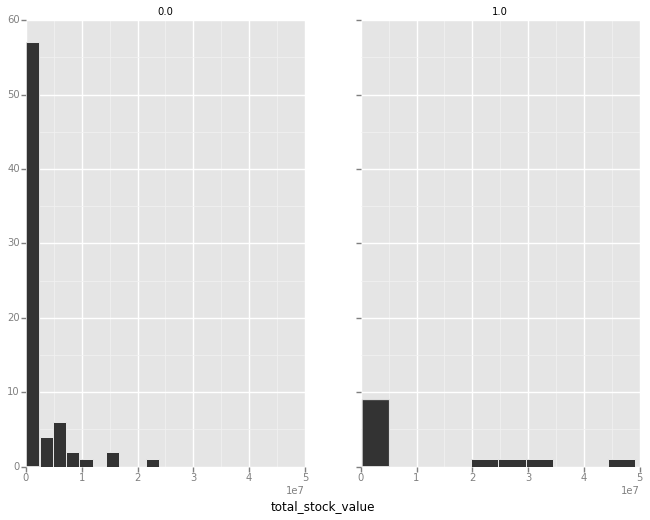

<ggplot: (292343541)>

In [56]:
ggplot(df_ff, aes(x='total_stock_value')) + geom_histogram() + facet_wrap("poi",ncol=2)

**Use median to impute missing values in total_stock_value** since the distribution is not bell curve and too sensetive to outliers, average is not a good candidate

In [57]:
pos_totstock, neg_totstock = group_seperator(df_ff['total_stock_value'], df_ff['poi'])
median_pos_totstock = pos_totstock.median()
median_neg_totstock = neg_totstock.median()
print median_pos_totstock, median_neg_totstock
print df_ff['total_stock_value'].median()

1918887.0 1038185.0
1114549.5


In [58]:
totstock_impute_param = df_ff['total_stock_value'].median()
df_ff_copy['total_stock_value'].fillna(totstock_impute_param, inplace=True)
#totstock_impute_params = impute_feat_na(df_ff_copy['total_stock_value'], labels_train, method='median')
#df_ff_copy['total_stock_value'] = totstock_impute_params[0]

***
* step2: build linear regression model, use **total_stock_value** to impute missing values in **exercised_stock_options**

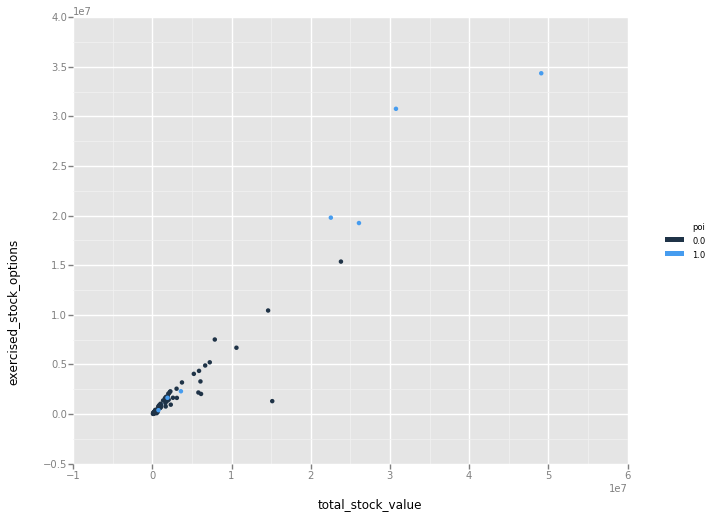

<ggplot: (292338057)>

In [59]:
# explore scatter plot
ggplot(df_ff, aes(x='total_stock_value', y='exercised_stock_options', color='poi'))\
+ geom_point() #+ scale_y_continuous(limits=(0, 2*10**7)) # change limits to zoom in and out to see trends

Disregard one outlier, **total_stock_value** and **exercised_stock_options** are very strongly and linearly correlated. Consider impute the 13 missing values in **total_stock_value**, then use a linear model to impute the 28 missing values in **exercised_stock_options**

Note: Skipped doing hypothesis test on linear relationship of **POI** and **non-POI** group, since judging from the scatter plot the linear relationship of two groups seems unseperable.

In [60]:
# identify and examine scatter outlier
scatter_outlier1 = df_ff.index[(df_ff['total_stock_value']>1.*10**7) & \
                               (df_ff['total_stock_value']<2.*10**7) & \
                               (df_ff['exercised_stock_options']<.5*10**7)]
print scatter_outlier1

Index([u'WHITE JR THOMAS E'], dtype='object')


In [61]:
df_ff_copy.loc[scatter_outlier1]

,salary,total_payments,bonus,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,poi
WHITE JR THOMAS E,317543,1934359,450000,15144123,81353,1297049,1085463,NaN,13847074,0


In [62]:
def slr_imputation(feature, response, outlier_ids=None):
    '''
    tit a linear regression using non-NaN values in feature and response,
    then use fitted model to impute NaN values in response variable.
    Input Arguments:
        feature - pandas.Series, with no missing values
        response - pandas.Series, with missing values
        outlier_ids - list, tuple, or string, stores the outlier indices exclude for fitting lr model
    Output Arguments:
        lr_func - fitted lr model, can be used for prediction
        response_copy - pandas.Series, with missing value imputed
        r_value - pearson r, denotes the correlation btw feature and response;
                - its squre is determination of coefficient
        p_value - the statistical significance of the fitted model; p value of the fitted model
    '''
    response_copy = response.copy()
    train_index = response.index[~response.isnull()]
    test_index = response.index[response.isnull()]
    if outlier_ids is not None:
        train_index = list(set(train_index) - set(outlier_ids))
    slope, intercept, r_value, p_value, _ = linregress(feature.loc[train_index].values,
                                                       response.loc[train_index].values)
    print "pearson_r: ", r_value
    print "coefficient of determination: ", r_value**2
    print "p value: ", p_value
    lr_func = lambda ft : intercept + slope*ft
    response_copy.loc[test_index] = lr_func(feature.loc[test_index].values)
    return response_copy, lr_func, r_value, p_value

In [63]:
# fit linear regression model and impute missing values
stock_impute_params1 = slr_imputation(df_ff_copy['total_stock_value'],
                                     df_ff_copy['exercised_stock_options'],
                                     outlier_ids = scatter_outlier1)
df_ff_copy['exercised_stock_options'] = stock_impute_params1[0]

pearson_r:  0.98104152875
coefficient of determination:  0.962442481132
p value:  3.40293941218e-50


***
* step 3: build linear regression model, use **total_stock_value** to impute missing values in **restricted_stock_options** (discard outliers, **total_stock_value** is favored over **exercised_stock_options** b/z the former has less imputed values, and the former has higher correlation w.r.t. outcome variable)

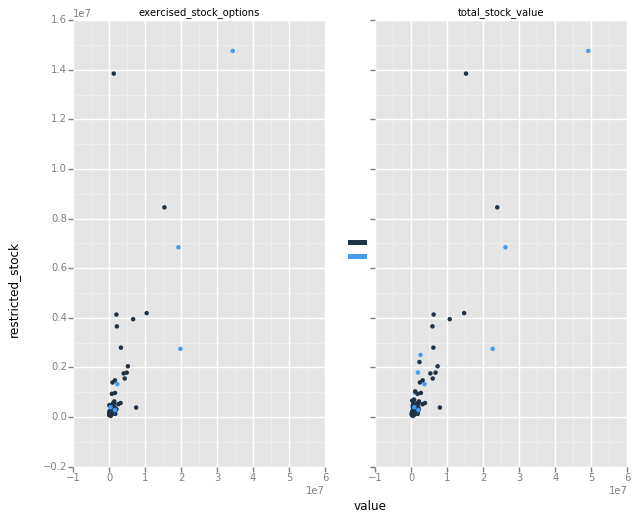

<ggplot: (292661901)>

In [64]:
# explore scatter plot
df_temp = pd.melt(df_ff[['total_stock_value', 'restricted_stock', 'exercised_stock_options', 'poi']], 
                  id_vars=['restricted_stock','poi'])
ggplot(df_temp, aes(x='value', y='restricted_stock', color='poi')) + geom_point() \
+ facet_wrap("variable",nrow=1) #+ scale_y_continuous(limits=(0, 0.6*10**7))

The scatter plots show that the response variable and exploratory variables are not perfectly lying on a stright line, however it demonstrates decent linearity. Pick **total_stock_value** since it has higher correlation w.r.t. outcome variable, and it has less imputed data points. Need to discard outlier impact while fitting linear regression models

In [65]:
# idenfity and explore outlier
outlier_a =  df_ff.index[(df_ff['total_stock_value']>2*10**7) & (df_ff['restricted_stock']<.4*10**7)]   
print outlier_a
outlier_b = df_ff.index[df_ff['restricted_stock']>1.2*10**7]
print outlier_b
scatter_outlier2 = outlier_a | outlier_b

Index([u'RICE KENNETH D'], dtype='object')
Index([u'WHITE JR THOMAS E', u'LAY KENNETH L'], dtype='object')


In [66]:
df_ff_copy.loc[scatter_outlier2]

,salary,total_payments,bonus,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,poi
LAY KENNETH L,1072321,103559793,7000000,49110078,99832,34348384,10359729,3600000,14761694,1
RICE KENNETH D,420636,505050,1750000,22542539,46950,19794175,174839,1617011,2748364,1
WHITE JR THOMAS E,317543,1934359,450000,15144123,81353,1297049,1085463,NaN,13847074,0


In [67]:
# fit linear regression model and impute missing values
stock_impute_params2 = slr_imputation(df_ff_copy['total_stock_value'],
                                     df_ff_copy['restricted_stock'],
                                     outlier_ids = scatter_outlier2)
df_ff_copy['restricted_stock'] = stock_impute_params2[0]

pearson_r:  0.911422678052
coefficient of determination:  0.830691298068
p value:  6.28360594889e-28


***
* examine **salary**
    * its correlation w.r.t. other financial features
    * its histogram sperated by **poi** and **non-poi** group
    * its scatter plot w.r.t. a few high correlation variables

In [68]:
colinear_stat['salary']

,salary_m,salary_r,salary_r2,salary_p
salary,62,1.000000,1.000000,0.000000e+00
total_payments,62,0.609404,0.371374,1.468131e-07
bonus,53,0.633571,0.401412,3.544063e-07
total_stock_value,59,0.691062,0.477567,1.376371e-09
expenses,56,0.132775,0.017629,3.293063e-01
exercised_stock_options,45,0.696519,0.485139,1.074901e-07
other,58,0.627978,0.394357,1.315817e-07
long_term_incentive,41,0.537429,0.288830,2.908489e-04
restricted_stock,56,0.572283,0.327508,4.064079e-06


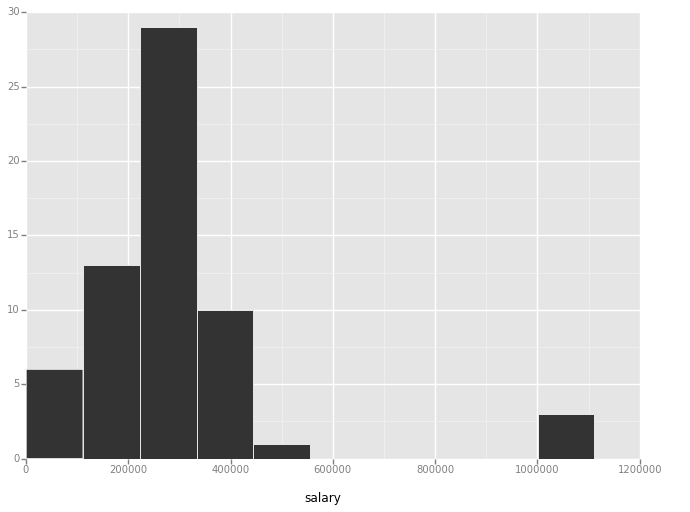

<ggplot: (294987649)>

In [78]:
ggplot(df_ff, aes(x='salary'))+geom_histogram()

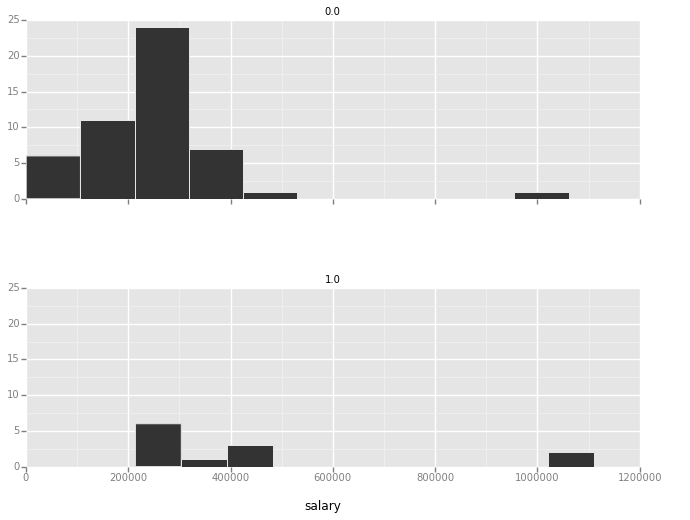

<ggplot: (294711269)>

In [77]:
ggplot(df_ff, aes(x='salary'))+geom_histogram()+facet_wrap('poi')

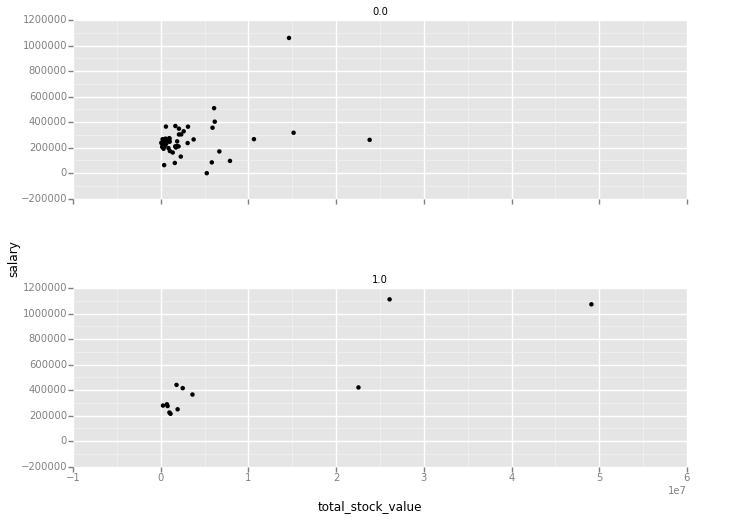

<ggplot: (293400353)>

In [70]:
ggplot(df_ff, aes(x='total_stock_value', y='salary')) + geom_point() + facet_wrap('poi')

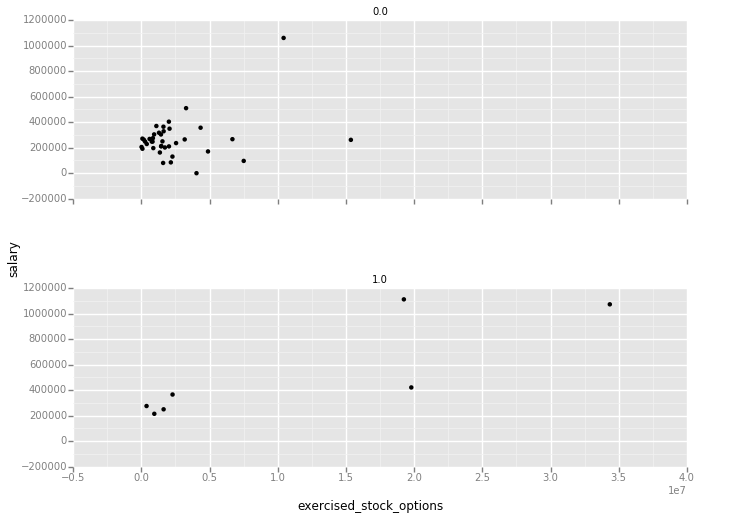

<ggplot: (294246445)>

In [71]:
ggplot(df_ff, aes(x='exercised_stock_options', y='salary')) + geom_point() + facet_wrap('poi')

The scatter plots indicate no reliable linear relationships. Therefore it is unable to use linear regression to impute the missing values in salary. However there is a clear seperation of historgram characteristics of salary from **poi** group and **non-poi** group. The salary of **non-poi** group demonstrates normal distribution bell curve suffers from outliers. Decide to impute missing values in **salary** attributes using mean (exclude outliers)

In [72]:
# identify and examine the outliers in salary attribute
salary_outliers = df_ff.index[df_ff['salary']>9.*10**5]
print salary_outliers

Index([u'SKILLING JEFFREY K', u'LAY KENNETH L', u'FREVERT MARK A'], dtype='object')


In [73]:
df_ff.loc[salary_outliers]

,salary,total_payments,bonus,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,poi
SKILLING JEFFREY K,1111258,8682716,5600000,26093672,29336,19250000,22122,1920000,6843672,1
LAY KENNETH L,1072321,103559793,7000000,49110078,99832,34348384,10359729,3600000,14761694,1
FREVERT MARK A,1060932,17252530,2000000,14622185,86987,10433518,7427621,1617011,4188667,0


In [75]:
pos_salary, neg_salary = group_seperator(df_ff['salary'], df_ff['poi'], outlier_ids=salary_outliers)
median_pos_salary = pos_salary.median()
median_neg_salary = neg_salary.median()
avg_pos_salary = pos_salary.mean()
avg_neg_salary = neg_salary.mean()
print "------medians------"
print median_pos_salary, median_neg_salary
print df_ff['salary'].median()
print "------means------"
print avg_pos_salary, avg_neg_salary
print (avg_pos_salary*len(pos_salary)+avg_neg_salary*len(neg_salary))/(len(pos_salary)+len(neg_salary))

------medians------
283571.5 248146.0
259647.5
------means------
317130.9 239033.020408
252269.949153


Decide to impute missing values in **salary** using sample mean after excluding outliers, since the overall distribution of **salary** is somewhat bell-curve/normal.

In [79]:
# impute NaNs in salary attribute using mean while excluding outliers/ median
selected_index = df_ff_copy.index.drop(salary_outliers)
salary_impute_param = df_ff_copy['salary'].loc[selected_index].mean()
df_ff_copy.fillna(salary_impute_param, inplace=True)
#salary_impute_params = impute_feat_na(df_ff_copy['salary'], labels_train, 
                                      #method='mean', outlier_ids=salary_outliers)
#df_ff_copy['salary'] = salary_impute_params[0]

252269.949153


***
* examine **bonus**
    * its correlation w.r.t. other financial features
    * its histogram sperated by **poi** and **non-poi** group
    * its scatter plot w.r.t. a few high correlation variables

In [80]:
colinear_stat['bonus']

,bonus_m,bonus_r,bonus_r2,bonus_p
salary,53,0.633571,0.401412,3.544063e-07
total_payments,53,0.634809,0.402982,3.308626e-07
bonus,53,1.000000,1.000000,0.000000e+00
total_stock_value,51,0.584549,0.341698,6.669545e-06
expenses,49,-0.017618,0.000310,9.043638e-01
exercised_stock_options,39,0.588938,0.346848,8.009784e-05
other,51,0.472754,0.223496,4.599084e-04
long_term_incentive,36,0.709057,0.502761,1.296241e-06
restricted_stock,51,0.433801,0.188183,1.471756e-03


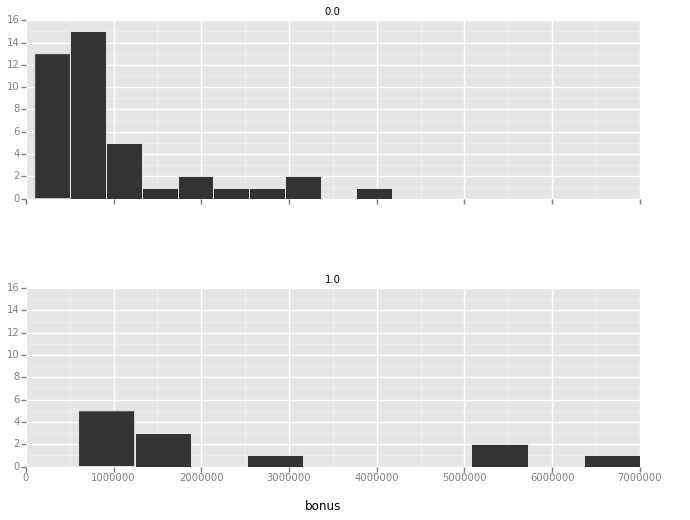

<ggplot: (295851945)>

In [84]:
ggplot(df_ff, aes(x='bonus'))+geom_histogram()+facet_wrap('poi')

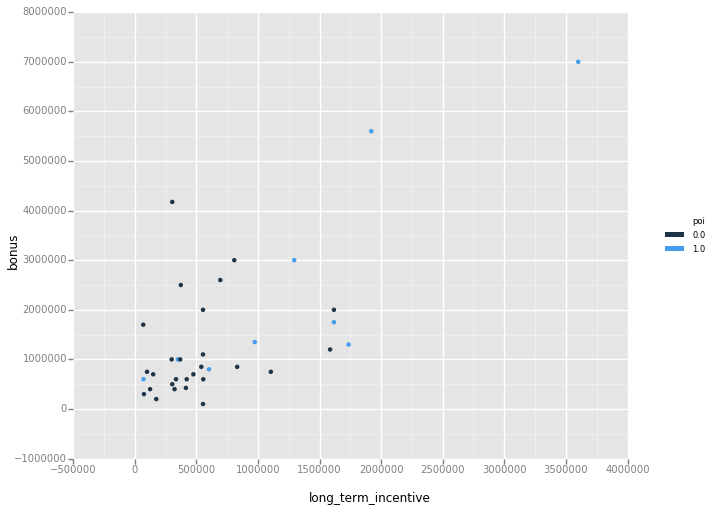

<ggplot: (295874945)>

In [85]:
ggplot(df_ff, aes(x='long_term_incentive', y='bonus', color='poi')) + geom_point()

In [86]:
pos_bonus, neg_bonus = group_seperator(df_ff['bonus'], df_ff['poi'])
median_pos_bonus = pos_bonus.median()
median_neg_bonus = neg_bonus.median()
avg_pos_bonus = pos_bonus.mean()
avg_neg_bonus = neg_bonus.mean()
print "------medians------"
print median_pos_bonus, median_neg_bonus
print df_ff['bonus'].median()

------medians------
1325000.0 700000.0
750000.0


There is some positive linear correlation shown in the scatter plot, but the scatter plot seems to suffer from heteroscedasticity, and given that **long_term_incentive** suffers a lot of missing value (~40%) and the coefficient of dertermination calculated from pearson_r_square is only 0.5, therefore not use linear regression to impute missing values for **bonus**.

Given the two histograms, decide to use sample median to impute missing values in **bonus** attribute.

In [87]:
bonus_impute_param = df_ff_copy['bonus'].median()
df_ff_copy['bonus'].fillna(bonus_impute_param, inplace=True)
#bonus_impute_params = impute_feat_na(df_ff_copy['bonus'], labels_train, method='median')
#df_ff_copy['bonus'] = bonus_impute_params[0]

***
* examine **long_term_incentive**
    * its correlation w.r.t. other financial features
    * its histogram sperated by **poi** and **non-poi** group
    * its scatter plot w.r.t. a few high correlation variables

In [88]:
colinear_stat['long_term_incentive']

,long_term_incentive_m,long_term_incentive_r,long_term_incentive_r2,long_term_incentive_p
salary,41,0.537429,0.288830,2.908489e-04
total_payments,42,0.549531,0.301985,1.637328e-04
bonus,36,0.709057,0.502761,1.296241e-06
total_stock_value,40,0.558871,0.312337,1.780911e-04
expenses,36,-0.150290,0.022587,3.816280e-01
exercised_stock_options,33,0.577416,0.333409,4.342703e-04
other,41,0.611501,0.373933,2.162993e-05
long_term_incentive,42,1.000000,1.000000,0.000000e+00
restricted_stock,37,0.813528,0.661827,9.344145e-10


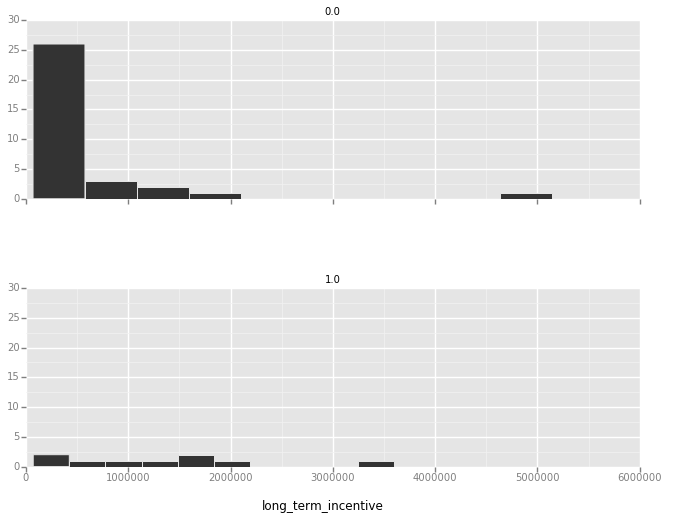

<ggplot: (296937093)>

In [91]:
ggplot(df_ff, aes(x='long_term_incentive'))+geom_histogram()+facet_wrap('poi')

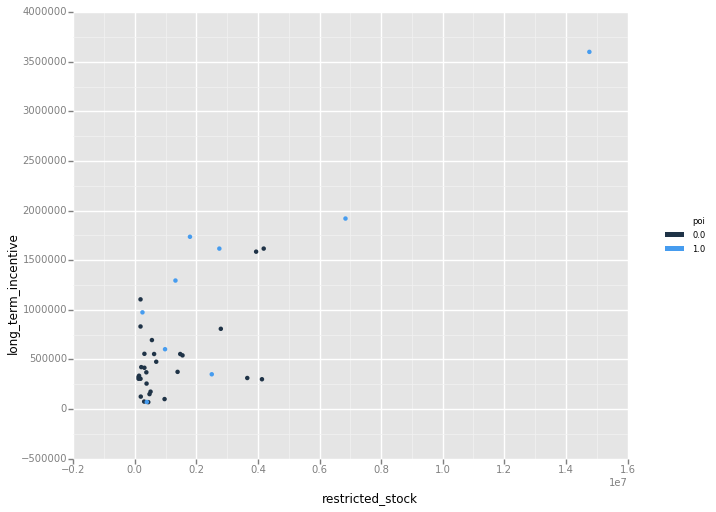

<ggplot: (297215125)>

In [92]:
ggplot(df_ff, aes(x='restricted_stock',y='long_term_incentive',color='poi'))+geom_point()

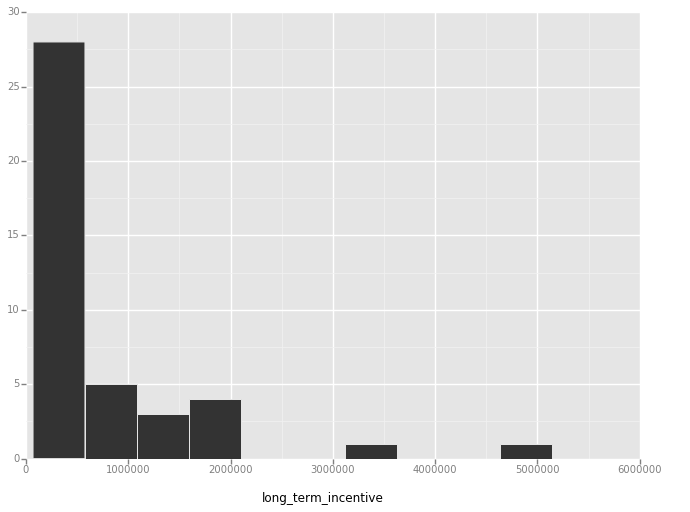

<ggplot: (297360013)>

In [93]:
ggplot(df_ff, aes(x='long_term_incentive'))+geom_histogram()

use sample sample median to fill in missing values in **long_term_incentive**

In [94]:
incentive_impute_param = df_ff_copy['long_term_incentive'].median()
df_ff_copy['long_term_incentive'].fillna(incentive_impute_param, inplace=True)

***
* Re-do boxplots

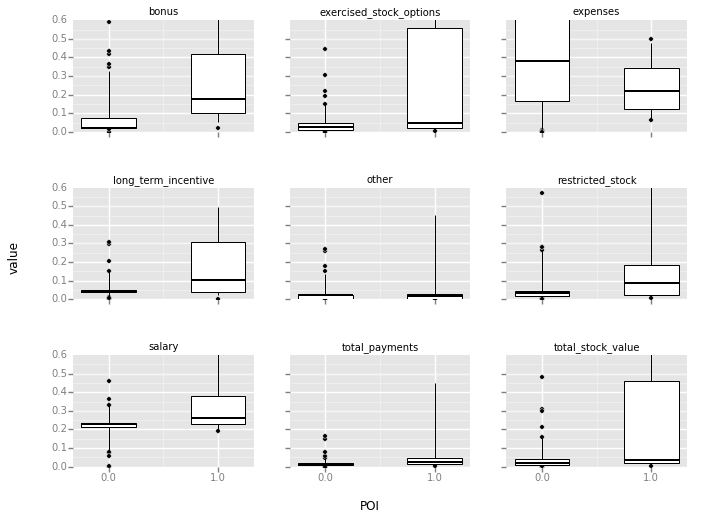

<ggplot: (297480045)>

In [95]:
ff_ps_cp = exp_boxplot_ggplot_df(df_ff_copy.drop(['poi'], axis=1), df_ff_copy['poi'],
                                 normalizer=normalizer, yrange=(.0, .6))
ff_ps_cp

* selected finanical features to build models are:

In [120]:
select_finanical_features = ['salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 
                             'long_term_incentive', 'restricted_stock']

***
* explore email features
    * missing value distribution and imputation
    * engineer new variables

In [108]:
df_ef = features_train[email_features].copy()
df_ef['poi'] = labels_train
df_ef_na = df_ef.isnull()
df_ef_na_rows = df_ef_na.sum(axis=1)
na5_ef_index = df_ef.index[df_ef_na_rows==len(email_features)]
na4_ef_index = df_ef.index[df_ef_na_rows==len(email_features)-1]
print len(na5_ef_index)

41


In [109]:
df_ef.loc[na5_ef_index].head(5)

,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi,poi
CLINE KENNETH W,NaN,NaN,NaN,NaN,NaN,0
WODRASKA JOHN,NaN,NaN,NaN,NaN,NaN,0
DUNCAN JOHN H,NaN,NaN,NaN,NaN,NaN,0
BAZELIDES PHILIP J,NaN,NaN,NaN,NaN,NaN,0
FASTOW ANDREW S,NaN,NaN,NaN,NaN,NaN,1


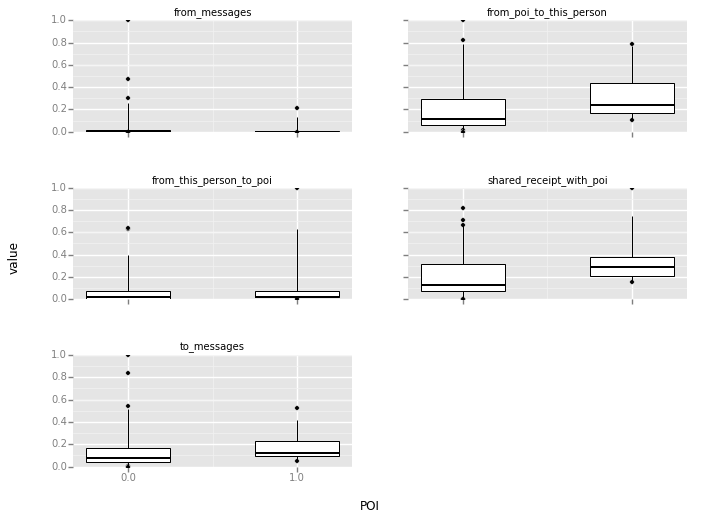

<ggplot: (299717893)>

In [110]:
ef_ps = exp_boxplot_ggplot_df(df_ef.drop(['poi'], axis=1), df_ef['poi'],
                                 normalizer=normalizer, yrange=(.0, 1.))
ef_ps

Select **to_messages**, **shared_receipt_with_poi**, **from_poi_to_this_person** as features
* Previously computed missing value percentage
    * shared_receipt_with_poi      0.415842
    * from_messages                0.415842
    * to_messages                  0.415842
    * from_poi_to_this_person      0.495050
    * from_this_person_to_poi      0.544554

In [113]:
df_ef.index[df_ef['from_messages'].isnull()] == df_ef.index[df_ef['to_messages'].isnull()]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [112]:
df_ef.index[df_ef['from_messages'].isnull()] == df_ef.index[df_ef['shared_receipt_with_poi'].isnull()]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [114]:
colinear_ef = calc_pearsonr(df_ef.drop(['poi'], axis=1))

***
* **examine from_poi_to_this_person**

In [140]:
colinear_ef['from_poi_to_this_person']

,from_poi_to_this_person_m,from_poi_to_this_person_r,from_poi_to_this_person_r2,from_poi_to_this_person_p
to_messages,51,0.428021,0.183202,0.001729
from_poi_to_this_person,51,1.000000,1.000000,0.000000
from_messages,51,0.069929,0.004890,0.625826
from_this_person_to_poi,45,0.187776,0.035260,0.216749
shared_receipt_with_poi,51,0.587078,0.344661,0.000006


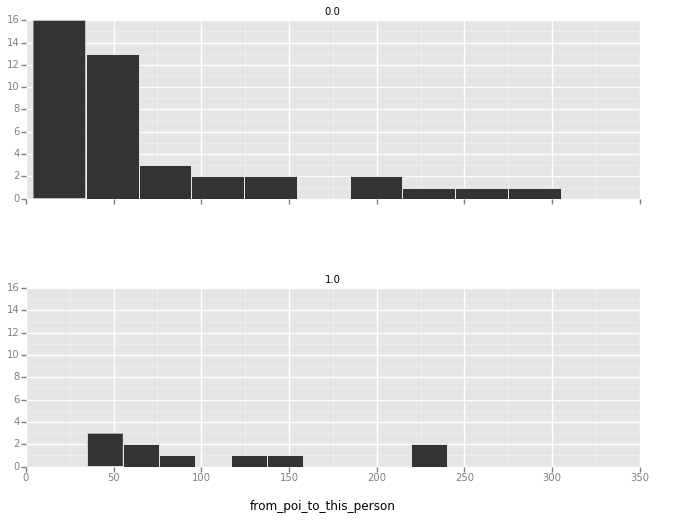

<ggplot: (303199637)>

In [141]:
ggplot(df_ef, aes('from_poi_to_this_person')) + geom_histogram() + facet_wrap('poi')

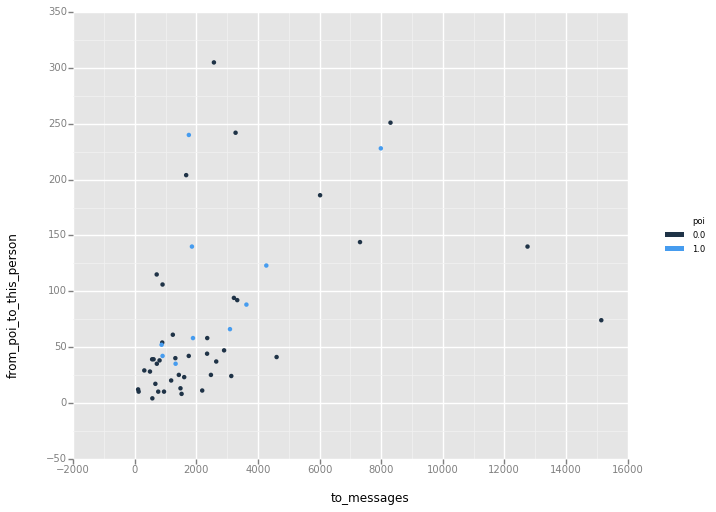

<ggplot: (303273477)>

In [143]:
ggplot(df_ef, aes(x='to_messages',y='from_poi_to_this_person', color='poi')) + geom_point()

***
* **examine to_messages**

In [131]:
colinear_ef['to_messages']

,to_messages_m,to_messages_r,to_messages_r2,to_messages_p
to_messages,59,1.000000,1.000000,0.000000e+00
from_poi_to_this_person,51,0.428021,0.183202,1.729214e-03
from_messages,59,0.445067,0.198085,4.124261e-04
from_this_person_to_poi,46,0.489188,0.239305,5.606902e-04
shared_receipt_with_poi,59,0.838547,0.703161,1.154388e-16


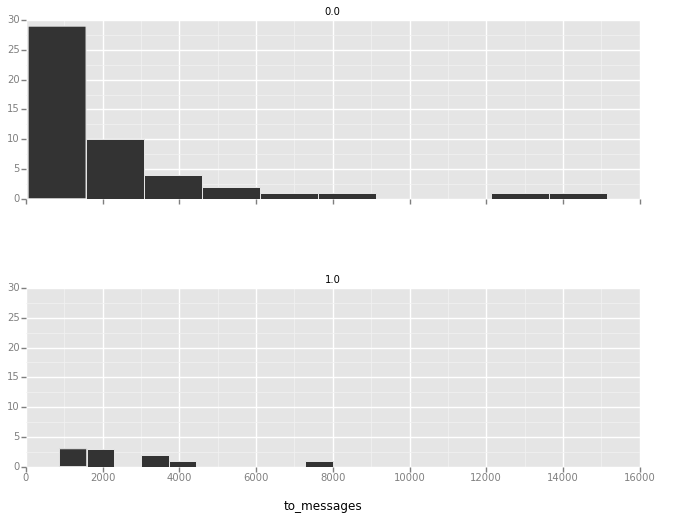

<ggplot: (301916749)>

In [132]:
ggplot(df_ef, aes(x='to_messages'))+geom_histogram()+facet_wrap('poi')

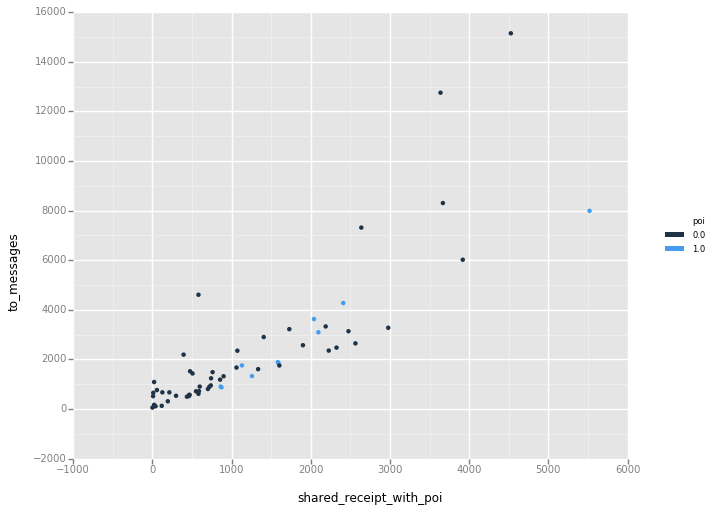

<ggplot: (301951993)>

In [133]:
ggplot(df_ef, aes(x='shared_receipt_with_poi',y='to_messages', color='poi')) + \
geom_point()

***
* **examine shared_receipt_with_poi**

In [134]:
colinear_ef['shared_receipt_with_poi']

,shared_receipt_with_poi_m,shared_receipt_with_poi_r,shared_receipt_with_poi_r2,shared_receipt_with_poi_p
to_messages,59,0.838547,0.703161,1.154388e-16
from_poi_to_this_person,51,0.587078,0.344661,5.948422e-06
from_messages,59,0.187349,0.035100,1.553508e-01
from_this_person_to_poi,46,0.366059,0.133999,1.235233e-02
shared_receipt_with_poi,59,1.000000,1.000000,0.000000e+00


***
* **explore engineering new features**

In [158]:
df_ef1 = df_ef.copy()
df_ef1['ratio_to_share'] = df_ef1['shared_receipt_with_poi']/df_ef1['to_messages']
df_ef1['ratio_from_share'] = df_ef1['shared_receipt_with_poi']/df_ef1['from_messages']

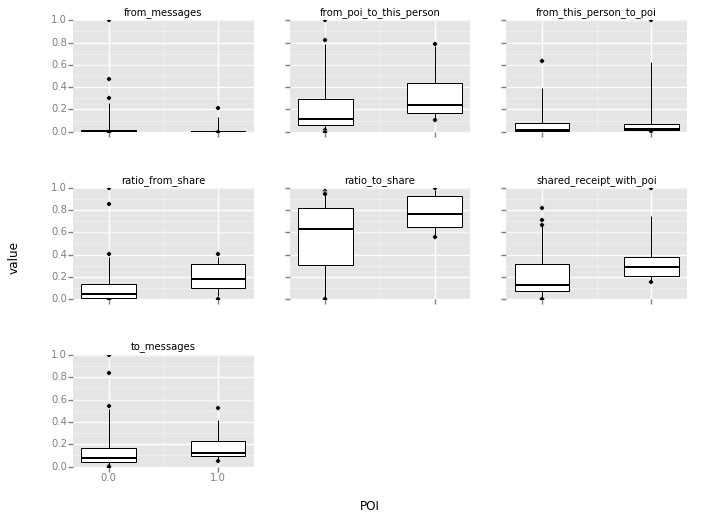

<ggplot: (311007381)>

In [159]:
ef_ps1 = exp_boxplot_ggplot_df(df_ef1.drop(['poi'], axis=1), df_ef['poi'],
                                 normalizer=normalizer, yrange=(.0, 1.))
ef_ps1

***
* Preprocess email_feature strategies
    * Impute **from_poi_to_this_person** using sample median or mean
    * Impute missing values in **from_messages** and **to_messages** using sample median or mean
    * Use **to_messages** and linear regression to impute missing values in **shared_receipt_with_poi**
    * Engineer **ratio_to** feature by applying **shared_receipt_with_poi**/**to_messages**
    * Engineer **ratio_from**feature by applying **shared_receipt_with_poi**/**from_messages**
***
* step 1: Impute **from_poi_to_this_person** using sample median or mean

In [160]:
pos_poi_to_person, neg_poi_to_person = group_seperator(df_ef['from_poi_to_this_person'], df_ef['poi'])
median_pos_poi_to_person = pos_poi_to_person.median()
median_neg_poi_to_person = neg_poi_to_person.median()
avg_pos_poi_to_person = pos_poi_to_person.mean()
avg_neg_poi_to_person = neg_poi_to_person.mean()
print "------medians------"
print median_pos_poi_to_person, median_neg_poi_to_person
print df_ef['from_poi_to_this_person'].median()
print "------means------"
print avg_pos_poi_to_person, avg_neg_poi_to_person
print df_ef['from_poi_to_this_person'].mean()

------medians------
77.0 39.0
42.0
------means------
107.2 68.2195121951
75.862745098


Impute **from_poi_to_this_person** with median

In [161]:
poitoperson_impute_param = features_train['from_poi_to_this_person'].median()
print poitoperson_impute_param

42.0


***
* step 2: Impute missing values in from_messages and to_messages using sample median or mean

In [162]:
pos_from, neg_from = group_seperator(df_ef['from_messages'], df_ef['poi'])
median_pos_from = pos_from.median()
median_neg_from = neg_from.median()
avg_pos_from = pos_from.mean()
avg_neg_from = neg_from.mean()
print "------medians------"
print median_pos_from, median_neg_from
print df_ef['from_messages'].median()
print "------means------"
print avg_pos_from, avg_neg_from
print df_ef['from_messages'].mean()

------medians------
44.5 40.0
40.0
------means------
392.9 814.795918367
743.288135593


Impute **from_messages** with sample median.

In [164]:
from_impute_param = features_train['from_messages'].median()
print from_impute_param

40.0


In [165]:
pos_to, neg_to = group_seperator(df_ef['to_messages'], df_ef['poi'])
median_pos_to = pos_to.median()
median_neg_to = neg_to.median()
avg_pos_to = pos_to.mean()
avg_neg_to = neg_to.mean()
print "------medians------"
print median_pos_to, median_neg_to
print df_ef['to_messages'].median()
print "------means------"
print avg_pos_to, avg_neg_to
print df_ef['to_messages'].mean()

------medians------
1875.0 1238.0
1433.0
------means------
2759.8 2270.51020408
2353.44067797


Impute **to_messages** with sample median

In [167]:
to_impute_param = features_train['to_messages'].median()
print to_impute_param

1433.0


***
* step 3: Use **to_messages** and linear regression to impute missing values in **shared_receipt_with_poi**

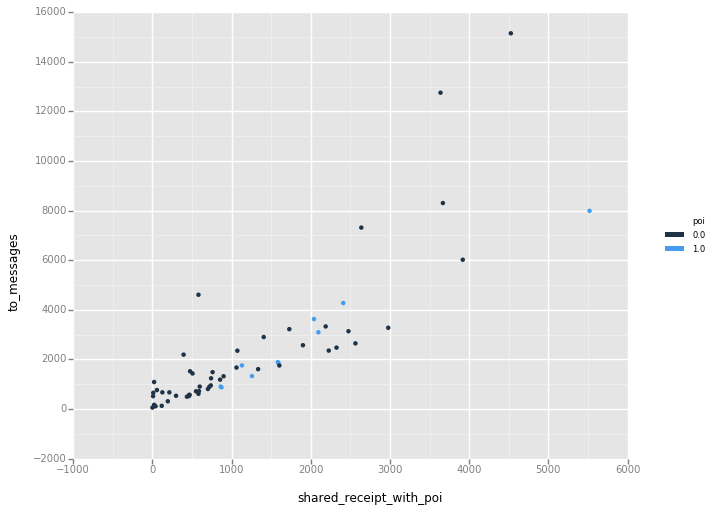

<ggplot: (312124833)>

In [168]:
# scatter plot
ggplot(df_ef, aes(x='shared_receipt_with_poi',y='to_messages', color='poi')) + geom_point()

In [173]:
# idenfity outliers
outlier_x = df_ef.index[(df_ef['to_messages']>4000) & (df_ef['shared_receipt_with_poi']<1000)]
print outlier_x
outlier_y = df_ef.index[(df_ef['to_messages']>7000) & (df_ef['shared_receipt_with_poi']<4000)]
print outlier_y
outlier_z = df_ef.index[(df_ef['to_messages']>15000)]
print outlier_z
outliers_share = outlier_x | outlier_y | outlier_z
print outliers_share

Index([u'KAMINSKI WINCENTY J'], dtype='object')
Index([u'BECK SALLY W', u'KITCHEN LOUISE', u'KEAN STEVEN J'], dtype='object')
Index([u'SHAPIRO RICHARD S'], dtype='object')
Index([u'BECK SALLY W', u'KAMINSKI WINCENTY J', u'KEAN STEVEN J',
       u'KITCHEN LOUISE', u'SHAPIRO RICHARD S'],
      dtype='object')


In [174]:
share_impute_params2 = slr_imputation(df_ef['to_messages'],
                                      df_ef['shared_receipt_with_poi'],
                                      outlier_ids = outliers_share)

pearson_r:  0.940016433964
coefficient of determination:  0.883630896123
p value:  6.01785917198e-26


***
* step 4: engineer **ratio_to** feature by applying **shared_receipt_with_poi**/**to_messages**
* step 5: engineer **ratio_from**feature by applying **shared_receipt_with_poi**/**from_messages**

***
### Summary 

**Financial Features**
    * salary - use sample mean to impute missing data ((exclude outliers) )
    * bonus - use sample median to impute missing data
    * total_stock_value - use sampe median to impute missing data
    * exercised_stock_options - use imputed total_stock_value to linearly predict missing data (exclude outliers)
    * restricted_stock - use imputed total_stock_value to linearly predict missing data (exclude outliers)
    * long_term_incentive - use sample median to impute missing data

**Email Features**
    * from_poi_to_this_person - use sample median to impute missing data
    * to_messages - use sample median to impute missing data
    * shared_receipt_with_poi - use imputed to_messages to linearly predict missing data (exclude outliers)
    * ratio_from - use sample median to impute from_messages, then calculate shared_receipt_with_poi/from_messages
    * ratio_to - use impted to_messages, then calculate shared_receipt_with_poi/to_messages

In [175]:
select_finanical_features

['salary',
 'bonus',
 'total_stock_value',
 'exercised_stock_options',
 'long_term_incentive',
 'restricted_stock']